In [73]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [74]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [75]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import random
import pickle
import pandas as pd

np.random.seed(0)

In [76]:
with open('german-traffic-signs/train.p', 'rb') as f:
  train_data = pickle.load(f)

with open('german-traffic-signs/valid.p', 'rb') as f:
  validation_data = pickle.load(f)

with open('german-traffic-signs/test.p', 'rb') as f:
  test_data = pickle.load(f)

X_train, Y_train = train_data['features'], train_data['labels']
X_validation, Y_validation = validation_data['features'], validation_data['labels']
X_test, Y_test = test_data['features'], test_data['labels']

In [77]:
assert(X_train.shape[0] == Y_train.shape[0]), "The number of training images is not equal to the number of labels."
assert(X_validation.shape[0] == Y_validation.shape[0]), "The number of validation images is not equal to the number of labels."
assert(X_test.shape[0] == Y_test.shape[0]), "The number of test images is not equal to the number of labels."

assert(X_train.shape[1:] == (32, 32, 3)), "The dimensions of the training images is not 32 x 32 x 3."
assert(X_validation.shape[1:] == (32, 32, 3)), "The dimensions of the validation images is not 32 x 32 x 3."
assert(X_test.shape[1:] == (32, 32, 3)), "The dimensions of the test images is not 32 x 32 x 3."

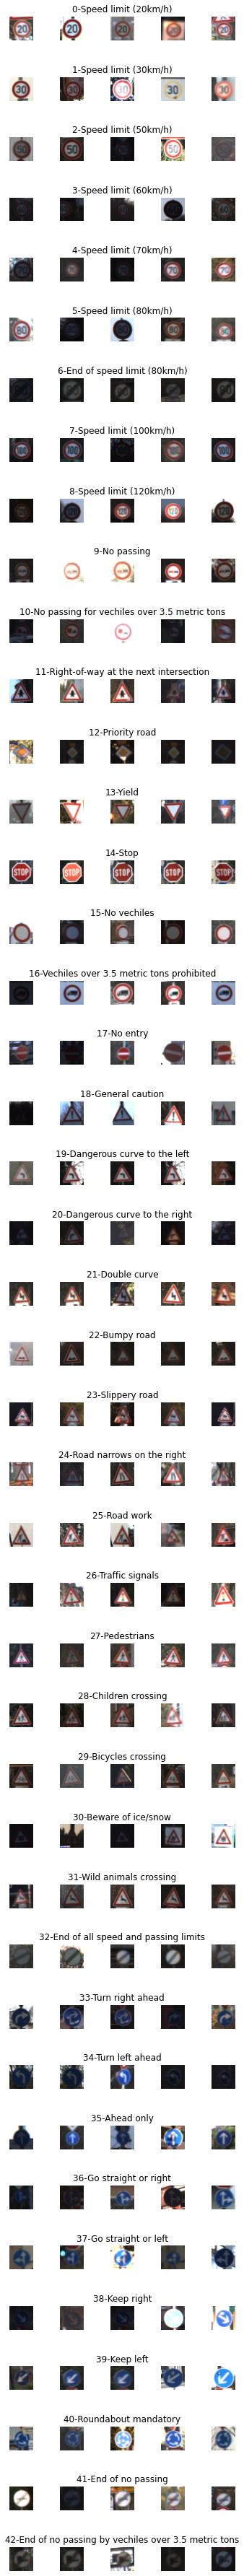

In [78]:
data = pd.read_csv('german-traffic-signs/signnames.csv')

num_of_samples = []
 
cols = 5
num_classes = 43
 
fig, axs = plt.subplots(nrows=num_classes, ncols = cols, figsize=(5, 50))
fig.tight_layout()
for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[Y_train == j]
        axs[j][i].imshow(x_selected[random.randint(1, len(x_selected - 1)), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j)+ "-" + row["SignName"])
            num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


Text(0, 0.5, 'Number of images')

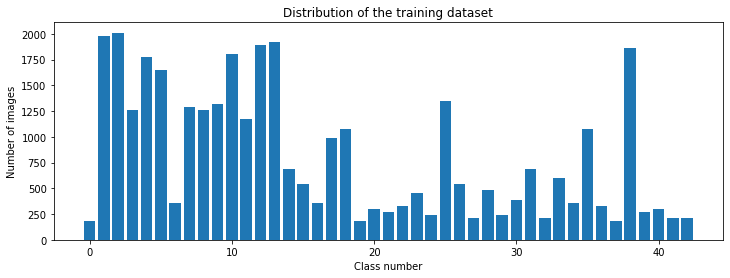

In [79]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")

(32, 32, 3)
40


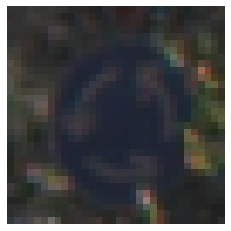

In [80]:
import cv2 

plt.imshow(X_train[4444])
plt.axis('off')
print(X_train[4444].shape)
print(Y_train[4444])

In [81]:
def grayscale(img):
  grayimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return grayimg

(32, 32)


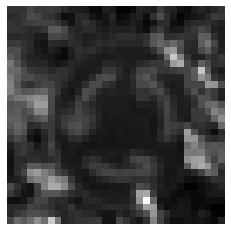

In [82]:
grayimg = grayscale(X_train[4444])
plt.imshow(grayimg , cmap=plt.get_cmap('gray'))
plt.axis('off')
print(grayimg.shape)

In [83]:
def equalize(img):
  equalimg = cv2.equalizeHist(img)
  return equalimg

(32, 32)


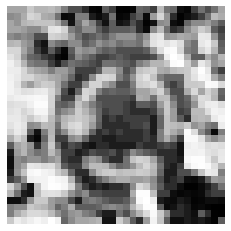

In [84]:
equalimg =  equalize(grayimg)

plt.imshow(equalimg , cmap=plt.get_cmap('gray'))
plt.axis('off')
print(equalimg.shape)

In [85]:
def preprocessing(img):
  gray = grayscale(img)
  equal = equalize(gray)
  normalize = equal/255
  return normalize


In [86]:
X_train = np.array(list(map(preprocessing, X_train)))
X_validation = np.array(list(map(preprocessing, X_validation)))
X_test = np.array(list(map(preprocessing, X_test)))

(34799, 32, 32)


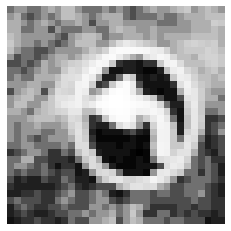

In [87]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)],  cmap=plt.get_cmap('gray'))
plt.axis('off')
print(X_train.shape)

In [88]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_validation = X_validation.reshape(4410, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)

In [89]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(width_shift_range = 0.1, 
                             height_shift_range = 0.1, 
                             zoom_range = 0.2, 
                             shear_range = 0.1,
                             rotation_range = 10)
datagen.fit(X_train)

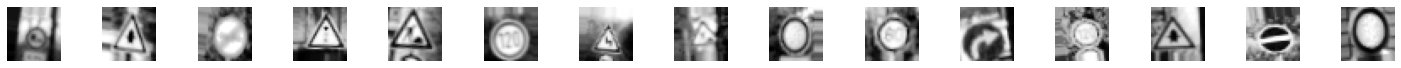

In [90]:
batches = datagen.flow(X_train, Y_train, batch_size = 20)
X_batch, Y_batch = next(batches)

fig, axis = plt.subplots(1, 15, figsize=(20,5))
fig.tight_layout()

for i in range(15):
  axis[i].imshow(X_batch[i].reshape(32,32), cmap=plt.get_cmap('gray'))
  axis[i].axis('off')

In [91]:
Y_train = to_categorical(Y_train, 43)
Y_validation = to_categorical(Y_validation, 43)
Y_test = to_categorical(Y_test, 43)

In [92]:
def modded_model():
  model = Sequential()
  model.add(Conv2D(60, (5,5), input_shape = (32, 32, 1), activation = 'relu'))
  model.add(Conv2D(60, (5,5), activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2,2)))

  model.add(Conv2D(30, (3,3), activation = 'relu'))
  model.add(Conv2D(30, (3,3), activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2,2)))
  model.add(Dropout(0.5))
  
  model.add(Flatten())
  model.add(Dense(500, activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation = 'softmax'))
  model.compile(Adam(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
  return model

In [93]:
model = modded_model()
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 28, 28, 60)        1560      
                                                                 
 conv2d_9 (Conv2D)           (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 12, 12, 60)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 10, 10, 30)        16230     
                                                                 
 conv2d_11 (Conv2D)          (None, 8, 8, 30)          8130      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 4, 4, 30)         0         
 2D)                                                  

In [94]:
history = model.fit(datagen.flow(X_train, Y_train, batch_size = 50), steps_per_epoch = 695, epochs = 10, validation_data = (X_validation, Y_validation), shuffle = 1)

Epoch 1/10
695/695 [==============================] - 14s 19ms/step - loss: 2.3039 - accuracy: 0.3480 - val_loss: 0.7526 - val_accuracy: 0.7839
Epoch 2/10
695/695 [==============================] - 13s 19ms/step - loss: 0.9909 - accuracy: 0.6916 - val_loss: 0.2617 - val_accuracy: 0.9295
Epoch 3/10
695/695 [==============================] - 13s 18ms/step - loss: 0.6577 - accuracy: 0.7953 - val_loss: 0.1588 - val_accuracy: 0.9519
Epoch 4/10
695/695 [==============================] - 14s 20ms/step - loss: 0.5080 - accuracy: 0.8411 - val_loss: 0.1572 - val_accuracy: 0.9492
Epoch 5/10
695/695 [==============================] - 13s 19ms/step - loss: 0.4118 - accuracy: 0.8688 - val_loss: 0.0821 - val_accuracy: 0.9764
Epoch 6/10
695/695 [==============================] - 13s 19ms/step - loss: 0.3744 - accuracy: 0.8818 - val_loss: 0.0773 - val_accuracy: 0.9760
Epoch 7/10
695/695 [==============================] - 13s 19ms/step - loss: 0.3212 - accuracy: 0.8972 - val_loss: 0.1024 - val_accuracy:

Text(0.5, 0, 'epoch')

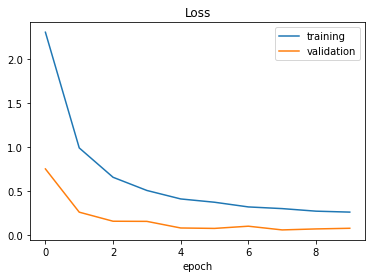

In [95]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

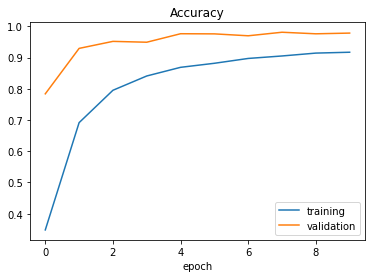

In [96]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [97]:
score = model.evaluate(X_test, Y_test, verbose = 0)
print('Test Score', score[0])
print('Test Accuracy', score[1])

Test Score 0.19542865455150604
Test Accuracy 0.9448139071464539


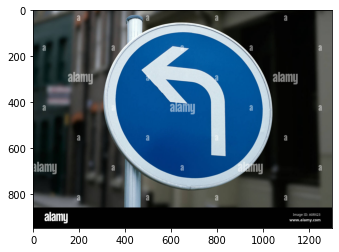

In [98]:
#fetch image
 
import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

(32, 32)
predicted sign: [34]


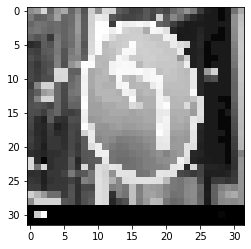

In [99]:
#Preprocess image
 
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)
 
#Reshape reshape
 
img = img.reshape(1, 32, 32, 1)
 
#Test image
test_img = np.argmax(model.predict(img),axis=1)
print("predicted sign: "+ str(test_img))